<a href="https://colab.research.google.com/github/ClaraNicolini/regressoes/blob/main/Rede_Neural_v6_reglog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from datetime import datetime
import joblib
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(df.head())

Saving startup_growth_investment_data.csv to startup_growth_investment_data.csv
  Startup Name    Industry  Funding Rounds  Investment Amount (USD)  \
0    Startup_1  Blockchain               8             1.335166e+09   
1    Startup_2        SaaS               2             2.781498e+09   
2    Startup_3      EdTech              10             3.309032e+09   
3    Startup_4     Fintech               5             4.050196e+09   
4    Startup_5      EdTech               9             1.645080e+09   

   Valuation (USD)  Number of Investors    Country  Year Founded  \
0     6.621448e+09                   50    Germany          2012   
1     8.363214e+09                   36         UK          2006   
2     1.548270e+10                   39  Singapore          2016   
3     1.268253e+10                   44     France          2021   
4     6.887966e+09                   48      India          2011   

   Growth Rate (%)  
0            77.10  
1           105.52  
2           190.47  


ROC-AUC por fold: [0.507 0.516 0.498 0.49  0.508]
Média ROC-AUC:    0.504


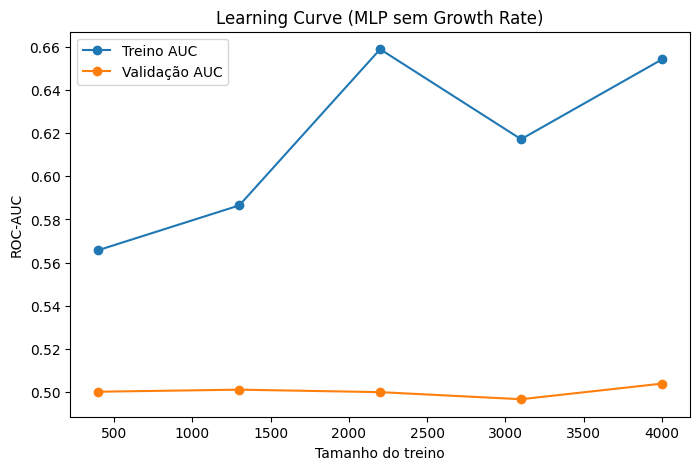


=== Classification Report (final split) ===
              precision    recall  f1-score   support

           0       0.24      0.39      0.30       236
           1       0.77      0.62      0.69       764

    accuracy                           0.57      1000
   macro avg       0.50      0.51      0.49      1000
weighted avg       0.64      0.57      0.60      1000



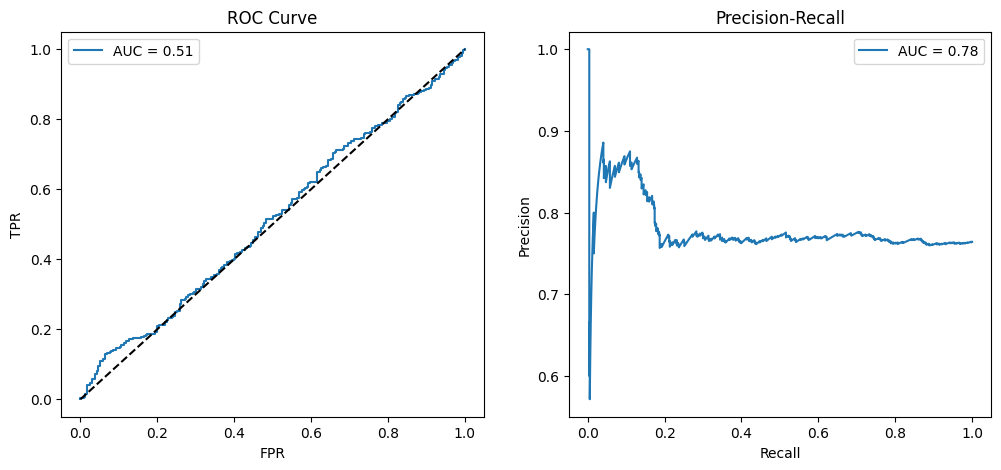

In [ ]:
df['Viable'] = (df['Growth Rate (%)'] > 50).astype(int)

numeric_features = [
    'Funding Rounds',
    'Investment Amount (USD)',
    'Valuation (USD)',
    'Number of Investors',
    'Year Founded'
]
categorical_features = ['Industry', 'Country']

X = df[numeric_features + categorical_features]
y = df['Viable']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

pipeline = ImbPipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(32,),
        activation='relu',
        solver='adam',
        alpha=0.01,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        max_iter=500,
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("ROC-AUC por fold:", np.round(roc_auc_scores, 3))
print("Média ROC-AUC:   ", np.round(roc_auc_scores.mean(), 3))

train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X, y,
    train_sizes=np.linspace(0.1,1.0,5),
    cv=cv, scoring='roc_auc', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
val_mean   = np.mean(val_scores,   axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Treino AUC')
plt.plot(train_sizes, val_mean,   'o-', label='Validação AUC')
plt.xlabel('Tamanho do treino')
plt.ylabel('ROC-AUC')
plt.title('Learning Curve (MLP sem Growth Rate)')
plt.legend()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
pipeline.fit(X_train, y_train)
y_pred  = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("\n=== Classification Report (final split) ===")
print(classification_report(y_test, y_pred))
=
fpr, tpr, _   = roc_curve(y_test, y_proba)
roc_auc_final = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc_final = auc(recall, precision)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_final:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AUC = {pr_auc_final:.2f}')
plt.title('Precision-Recall')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend()
plt.show()

In [ ]:
joblib.dump(pipeline, 'mlp_viability_model.pkl')
files.download("mlp_viability_model.pkl")
print("Modelo salvo com sucesso!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo salvo com sucesso!


In [ ]:
model = model = joblib.load('mlp_viability_model.pkl')
print('modelo carregado com sucesso!')

modelo carregado com sucesso!


In [ ]:
#valores podem ser inseridos nessa seção para o cálculo de viabilidade
startup_to_sell_data = {
    'Funding Rounds': [5],
    'Investment Amount (USD)': [2000000000],
    'Valuation (USD)': [8000000000],
    'Number of Investors': [20],
    'Year Founded': [2015],
    'Industry': ['Fintech'],
    'Country': ['France']
}
df_new = pd.DataFrame(startup_to_sell_data)

y_pred_new = model.predict(df_new)
y_proba_new = model.predict_proba(df_new)[:, 1]

print("Predição (classe):", y_pred_new[0])
print("Probabilidade de ser viável:", round(y_proba_new[0], 2))

Predição (classe): 0
Probabilidade de ser viável: 0.49
